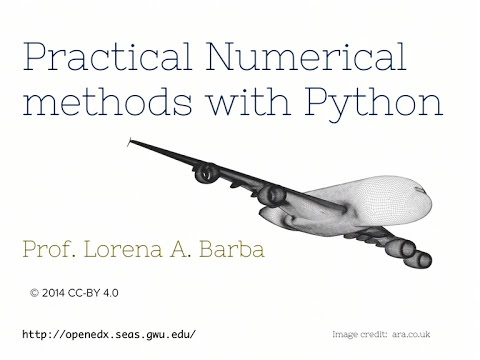

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('6i6qhqDCViA')

In [2]:
from math import sin, cos, log
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
reParams['font.family'] = 'serif'
reParams['font.size'] = 16

NameError: name 'reParams' is not defined